# Lesson 2 : LangGraph Components

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [6]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [8]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [13]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(
    model_name='qwen2',
    #model_name='deepseek-r1:32b',
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=True
)
abot = Agent(model, [tool], system=prompt)

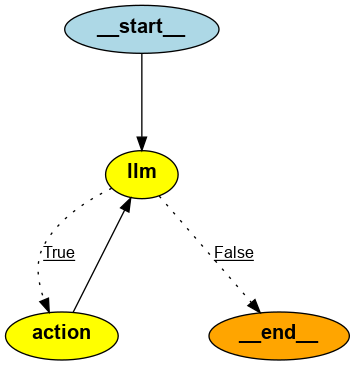

In [14]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [15]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_o4hrkbpk', 'type': 'tool_call'}
Back to the model!


In [16]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_o4hrkbpk', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'qwen2', 'system_fingerprint': 'fp_ollama'}, id='run-ca3bf189-4871-4a29-89ca-4770b2f2fcfa-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_o4hrkbpk', 'type': 'tool_call'}]),
  ToolMessage(content='[{\'title\': \'Weather in san francisco\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1741442638, \'localtime\': \'2025-03-08 06:03\'}, \'cur

In [17]:
result['messages'][-1].content

"The temperature in San Francisco is currently 5.6 degrees Celsius, with clear conditions. The wind speed is at 4.3 mph, and the humidity level is quite high at 96%. There's only a small chance of rain around 2% throughout the day until midnight.\n\nYou can check this information regularly here: [Weather in san francisco](https://www.weatherapi.com/), for accurate updates."

In [18]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather conditions in SF and LA'}, 'id': 'call_nunlwalf', 'type': 'tool_call'}
Back to the model!


In [19]:
result['messages'][-1].content

'The weather in San Francisco:\n- The current temperature is about 18.4°C (65°F) with partly cloudy conditions. \n- Wind speed is approximately 2.2 mph and the humidity level is around 77%.  \n\nThe weather in Los Angeles:  \n- The forecast predicts temperatures ranging from 61 to 65°F throughout the day, with a low chance of rain (<1%).  \n- There seems to be moderate tree pollen based on your current location.\n  \nPlease note that these results might change by the time you read this response due to real-time fluctuation.'

In [21]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'who won super bowl 2024'}, 'id': 'call_0i68nxni', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'state headquarters winning team super bowl 2024'}, 'id': 'call_7awjh9r3', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'gdp of state where winning super bowl 2024 team is headquartered'}, 'id': 'call_ud5bz845', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl economic impact'}, 'id': 'call_m6ssbiq0', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)